<a href="https://colab.research.google.com/github/oliverbon/bc/blob/main/Modelado50casos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

data generatos / mini batches para cuando se trabaje con todo

In [ ]:
import cv2
import os
import time
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive 
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
dir_base = '/content/drive/MyDrive/50 imagenes Proyecto/data'
os.listdir(dir_base)

['cancer', 'not_cancer']

In [ ]:
dir_base

'/content/drive/MyDrive/50 imagenes Proyecto/data'

In [ ]:
def read_image_dataset():
  data = []

  inicio = time.perf_counter()

  for item in os.listdir(dir_base):
    path = dir_base +"/"+item
    all_images_paths = []

    for patient_folder in os.listdir(path):
      patient_path = path + "/" + patient_folder

      all_images_paths.extend(list(map(lambda s: patient_path + "/" + s, os.listdir(patient_path))))

    data.extend([[cv2.imread(path), 1 if item=='cancer' else 0] for path in all_images_paths])

  fin = time.perf_counter()

  print("Tiempo de ejecución:", fin - inicio, "segundos")

  return data

In [ ]:
data = read_image_dataset()

Tiempo de ejecución: 4.27922549899813 segundos


In [ ]:
np.random.shuffle(data)

In [ ]:
x = []
y = []
for image in data:
  x.append(image[0])
  y.append(image[1])

x_data = np.array(x)
y_data = np.array(y)

In [ ]:
x_data.shape, y_data.shape

((475, 512, 512, 3), (475,))

In [ ]:
np.unique(y_data, return_counts=True)

(array([0, 1]), array([229, 246]))

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=0)

In [ ]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.25, random_state=0)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((380, 512, 512, 3),
 (380,),
 (71, 512, 512, 3),
 (71,),
 (24, 512, 512, 3),
 (24,))

In [ ]:
from tensorflow.data import Dataset

train_ds = Dataset.from_tensor_slices((x_train, y_train))
validation_ds = Dataset.from_tensor_slices((x_val, y_val))
test_ds = Dataset.from_tensor_slices((x_test, y_test))

In [ ]:
train_ds, validation_ds, test_ds

(<TensorSliceDataset element_spec=(TensorSpec(shape=(512, 512, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <TensorSliceDataset element_spec=(TensorSpec(shape=(512, 512, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <TensorSliceDataset element_spec=(TensorSpec(shape=(512, 512, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Convolution2D, MaxPool2D, BatchNormalization, Flatten, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.initializers import GlorotNormal

# this configuration uses backend.set_image_data_format('channels_first')

"""
This design creates the same network than before but using the layer by layer configuration.
Notice the Input layer and each layer description.
Function returns a model which require inputs and outputs (could be multiple of each one)
"""
def get_model_design(filters: list, input_shape: tuple) -> Model:
    input_layer = Input(shape=input_shape)

    conv1_layer = Convolution2D(filters[0], (5, 5), padding='same', kernel_regularizer=l2(0.001), activation=relu)(input_layer)
    conv2_layer = Convolution2D(filters[1], (3, 3), padding='same', kernel_regularizer=l2(0.001), activation=relu)(conv1_layer)
    drop1_layer = Dropout(0.5)(conv2_layer)
    conv3_layer = Convolution2D(filters[1], (3, 3), padding='same', kernel_regularizer=l2(0.001), activation=relu)(drop1_layer) #OAZ
    maxpool1_layer = MaxPool2D(pool_size=(2, 2))(conv3_layer)
    drop2_layer = Dropout(0.5)( maxpool1_layer)
    maxpool2_layer = MaxPool2D(pool_size=(2, 2))(drop2_layer) #OAZ
    norm1_layer = BatchNormalization()(maxpool2_layer)

    flat1_layer = Flatten()(norm1_layer)
    drop1_layer = Dropout(0.5)(flat1_layer)
    pred_layer = Dense(1, kernel_initializer=GlorotNormal(), activation=sigmoid)(drop1_layer)

    model = Model(inputs=input_layer, outputs=pred_layer)
    return model

# for this example, we used 128 and 64 filters for the two first conv layers
# note the input size of 3 channel for an image size of 64x64 pixels
model = get_model_design([16, 8], (512, 512, 3))
model.summary()


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 512, 512, 3)]     0         
                                                                 
 conv2d_33 (Conv2D)          (None, 512, 512, 16)      1216      
                                                                 
 conv2d_34 (Conv2D)          (None, 512, 512, 8)       1160      
                                                                 
 dropout_24 (Dropout)        (None, 512, 512, 8)       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 512, 512, 8)       584       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 256, 256, 8)      0         
 g2D)                                                            
                                                          

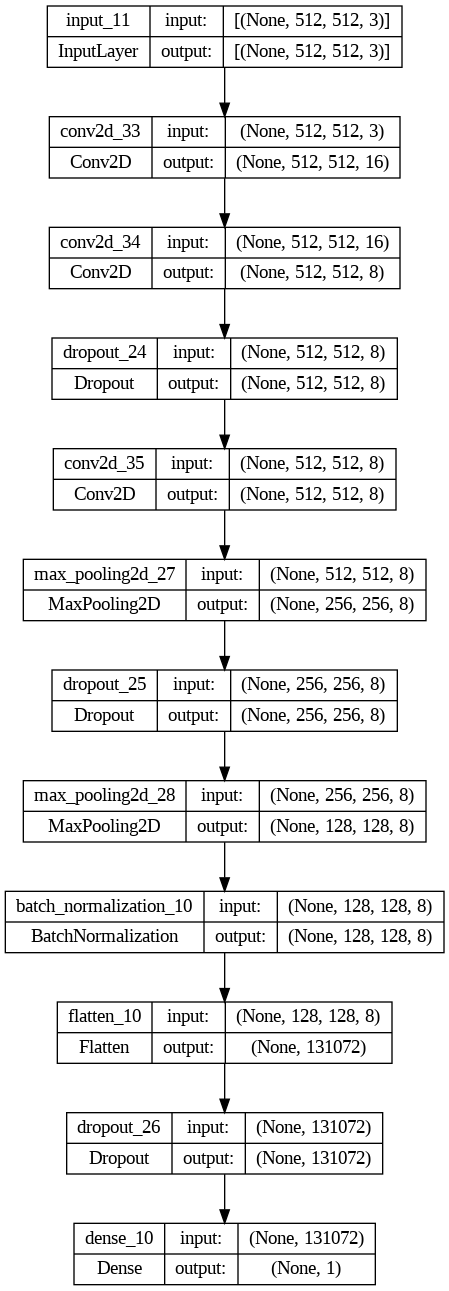

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, 'my-CNNmodel.png', show_shapes=True)

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.metrics import SpecificityAtSensitivity

"""
Definition of metrics commonly used on medical imaging classification, segmentation, and localization problems.
The metrics will appear on each iteration of the training process to monitor the progress of our design.
"""
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      SpecificityAtSensitivity(sensitivity=0.8, name='sensitivity'),
]

"""
For example, the loss function is to determine is an image contains or not a lesion/disease using the binary cross-entropy loss.
The optimizer is a first-order gradient-based optimization
"""
model.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(learning_rate=1e-3, beta_1=0.92, beta_2=0.999),
              metrics=METRICS)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

"""
This callback will stop the training when there is no improvement in the validation accuracy across epochs
"""
early_callback = EarlyStopping(monitor='val_auc', 
                               verbose=1,
                               patience=10,
                               mode='max',
                               restore_best_weights=True)

In [ ]:
batch_size = 64

"""
Training the model for 60 epochs using our dataset.
The batch size (64) is the same for the validation data.
Only 1 callback was used, but could be more like TensorBoard, ModelCheckpoint, etc.
"""
history = model.fit(train_ds.batch(batch_size=batch_size),
                    epochs=30,
                    validation_data=validation_ds.batch(batch_size=batch_size),
                    callbacks=[early_callback])

Epoch 1/30
6/6 [==============================] - 179s 29s/step - loss: 4.5070 - tp: 104.0000 - fp: 95.0000 - tn: 93.0000 - fn: 88.0000 - accuracy: 0.5184 - precision: 0.5226 - recall: 0.5417 - auc: 0.5138 - sensitivity: 0.0000e+00 - val_loss: 4.2740 - val_tp: 10.0000 - val_fp: 13.0000 - val_tn: 0.0000e+00 - val_fn: 1.0000 - val_accuracy: 0.4167 - val_precision: 0.4348 - val_recall: 0.9091 - val_auc: 0.5490 - val_sensitivity: 0.3077
Epoch 2/30
6/6 [==============================] - 172s 29s/step - loss: 3.2358 - tp: 62.0000 - fp: 46.0000 - tn: 142.0000 - fn: 130.0000 - accuracy: 0.5368 - precision: 0.5741 - recall: 0.3229 - auc: 0.5639 - sensitivity: 0.0000e+00 - val_loss: 1.1655 - val_tp: 7.0000 - val_fp: 7.0000 - val_tn: 6.0000 - val_fn: 4.0000 - val_accuracy: 0.5417 - val_precision: 0.5000 - val_recall: 0.6364 - val_auc: 0.5490 - val_sensitivity: 0.0000e+00
Epoch 3/30
6/6 [==============================] - 172s 29s/step - loss: 3.0688 - tp: 129.0000 - fp: 120.0000 - tn: 68.0000 - fn

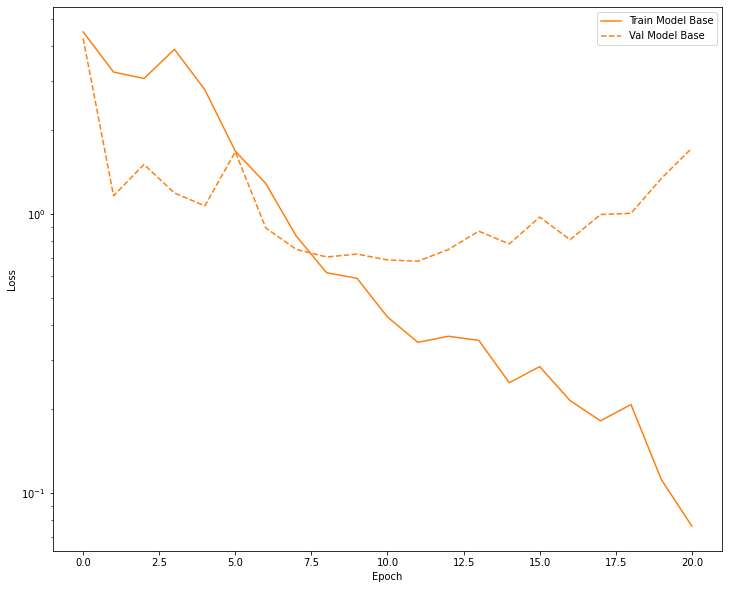

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from keras.callbacks import History

rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_log_loss(history: History, title_label: str, n: int) -> ():
    # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+title_label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+title_label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()

plot_log_loss(history, "Model Base", 1)

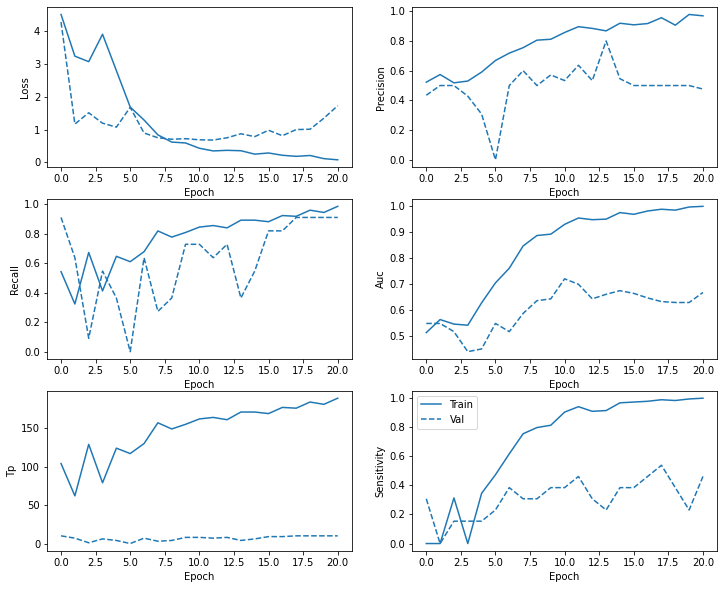

In [ ]:
def plot_metrics(history: History) -> ():
    metrics =  ['loss', 'precision', 'recall', 'auc', 'tp', 'sensitivity']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(3, 2, n+1)  # adjust according to metrics
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        # selecting the metric, the value of plt.ylim could be changed
    plt.legend()

plot_metrics(history)

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
score_test = model.evaluate(test_ds.batch(batch_size))
for name, value in zip(model.metrics_names, score_test):
    print(name, ': ', value)

Evaluate on test data
2/2 [==============================] - 7s 724ms/step - loss: 0.6765 - tp: 26.0000 - fp: 10.0000 - tn: 18.0000 - fn: 17.0000 - accuracy: 0.6197 - precision: 0.7222 - recall: 0.6047 - auc: 0.6719 - sensitivity: 0.3571
loss :  0.6765161156654358
tp :  26.0
fp :  10.0
tn :  18.0
fn :  17.0
accuracy :  0.6197183132171631
precision :  0.7222222089767456
recall :  0.604651153087616
auc :  0.6719269156455994
sensitivity :  0.3571428656578064


In [ ]:
y_train_pred  = model.predict(x_train)
y_test_pred = model.predict(x_test)

3/3 [==============================] - 7s 2s/step


Lesions Detected (True Negatives):  18
Lesions Incorrectly Detected (False Positives):  10
No-Lesions Missed (False Negatives):  17
No-Lesions Detected (True Positives):  26
Total Lesions:  43


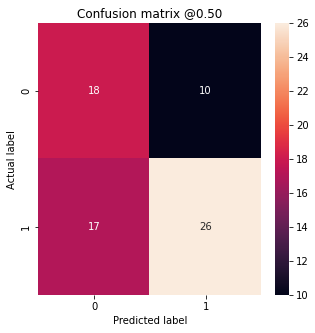

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy

# notice the threshold
def plot_cm(labels: numpy.ndarray, predictions: numpy.ndarray, p: float=0.5) -> ():
    cm = confusion_matrix(labels, predictions > p)
    # you can normalize the confusion matrix

    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Lesions Detected (True Negatives): ', cm[0][0])
    print('Lesions Incorrectly Detected (False Positives): ', cm[0][1])
    print('No-Lesions Missed (False Negatives): ', cm[1][0])
    print('No-Lesions Detected (True Positives): ', cm[1][1])
    print('Total Lesions: ', np.sum(cm[1]))

plot_cm(y_test, y_test_pred)

In [ ]:
precision = Precision()
precision.update_state(y_train, y_train_pred)
precision.result().numpy()

0.875

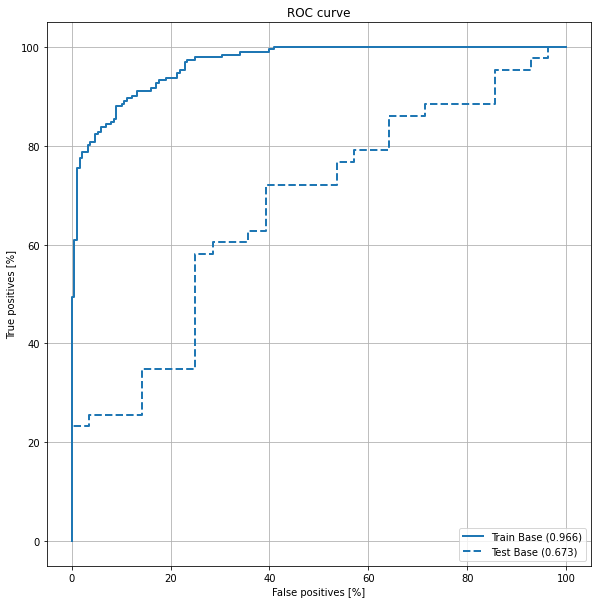

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc(name: str, labels: numpy.ndarray, predictions: numpy.ndarray, **kwargs) -> ():
  fp, tp, _ = roc_curve(labels, predictions)
  auc_roc = roc_auc_score(labels, predictions)
  plt.plot(100*fp, 100*tp, label=name + " (" + str(round(auc_roc, 3)) + ")", 
           linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.title('ROC curve')
  plt.grid(True)
  plt.legend(loc='best')
  ax = plt.gca()
  ax.set_aspect('equal')

plot_roc("Train Base", y_train, y_train_pred, color=colors[0])
plot_roc("Test Base", y_test, y_test_pred, color=colors[0], linestyle='--')
plt.legend(loc='lower right')